# Node-level membership inference attack (MIA) adapted for graph level predictions
## Keenan Hom
The original choice for MIA is here: https://arxiv.org/pdf/2102.05429. This notebook adapts it to be used for graph level predictions, suitable for our needs.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# import sys
# # Add the project root (the folder containing "main") to sys.path
# sys.path.append('..')
# from membership_inference_attack.ml_util import train_model

In [79]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from ml_util import (
    GATProteinsModel, GenericAttackModel, train_model_multi_graph, train_model, 
    load_model, get_accuracy, get_auroc_score, predict, predict_multi_graph
)
from util import create_attack_dataset, graph_train_test_split, onehot_transform, _get_onehot_transform

In [12]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
num_categories = 6
num_feat = 3

# dataset = Planetoid(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/', name='Citeseer', split='full', transform=cora_transform)
# dataset = PPI(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/PPI', split='train')
dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/ENZYMES', name='ENZYMES', transform=_get_onehot_transform(num_categories))
# dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/PROTEINS', name='PROTEINS', transform=onehot_transform)

# Transforms dataset.y
dataset = onehot_transform(dataset, categories=list(range(num_categories)))

In [55]:
# Split dataset in half for the target model dataset and shadow model dataset
t_dataset, s_dataset = graph_train_test_split(dataset, test_size=0.5)

# Split each dataset into train/test splits
t_dataset_train, t_dataset_test = graph_train_test_split(t_dataset, test_size=0.5)
s_dataset_train, s_dataset_test = graph_train_test_split(s_dataset, test_size=0.2)

In [56]:
lr = 0.001
epochs = 100
batch_size = 8
weight_decay = 1e-4
t_model = GATProteinsModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)
optimizer = optim.Adam(t_model.parameters(), lr=lr)
t_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5,
                                                       patience=50,
                                                       min_lr=1e-6,
                                                       verbose=True)

weight = compute_class_weight('balanced', classes=np.unique(t_dataset_train.y.argmax(dim=1)), y=t_dataset_train.y.argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
t_save_path = 'mia-models/t_model_gat_enzymes.pth'
# t_save_path = None

train_model_multi_graph(t_model, optimizer, t_dataset_train, loss_fn, epochs, batch_size, val_dataset=t_dataset_test, 
                        save_path=t_save_path, save_freq=10, scheduler=t_scheduler, device=DEVICE)
t_model.eval()

Learning rate: 0.001
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x1551b0662e60>
Training for 100 epochs, with batch size=8
Using validation data (150 samples)
Using device: cuda:0

-----Epoch 1/100-----
Batch 10/19 | loss: 1.76568 (0.120s) | train acc: 0.263, train AUC: 0.620
Batch 19/19 | loss: 1.81697 (0.105s) | train acc: 0.207, train AUC: 0.549
Validation: val loss: 1.874 | val acc: 0.153 | val F1: 0.056 | val AUC: 0.532

-----Epoch 2/100-----
Batch 10/19 | loss: 1.70467 (0.111s) | train acc: 0.163, train AUC: 0.626
Batch 19/19 | loss: 1.71111 (0.098s) | train acc: 0.193, train AUC: 0.620
Validation: val loss: 1.860 | val acc: 0.180 | val F1: 0.128 | val AUC: 0.533

-----Epoch 3/100-----
Batch 10/19 | loss: 1.61437 (0.111s) | train acc: 0.362, train AUC: 0.667
Batch 19/19 | loss: 1.75720 (0.099s) | train acc: 0.333, train AUC: 0.635
Validation: val loss: 1.848 | val acc: 0.260 | val F1: 0.218 | val AUC: 0.601

-----Epoch 4/100-----
Batch 10/19 | loss: 1.66198 

GATProteinsModel(
  (embedding): Linear(in_features=3, out_features=144, bias=True)
  (gat_layers): ModuleList(
    (0-2): 3 x GATConv(144, 18, heads=8)
    (3): GATConv(144, 144, heads=1)
  )
  (bns): ModuleList(
    (0-3): 4 x BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): MLP(144, 72, 36, 6)
)

In [57]:
# Create and train shadow model
lr = 0.001
epochs = 100
batch_size = 8
weight_decay = 1e-4
s_model = GATProteinsModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)
optimizer = optim.Adam(s_model.parameters(), lr=lr, weight_decay=weight_decay)
s_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5,
                                                       patience=50,
                                                       min_lr=1e-6,
                                                       verbose=True)
weight = compute_class_weight('balanced', classes=np.unique(s_dataset_train.y.argmax(dim=1)), y=s_dataset_train.y.argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
s_save_path = 'mia-models/s_model_gat_enzymes.pth'
# s_save_path = None

train_model_multi_graph(s_model, optimizer, s_dataset_train, loss_fn, epochs, batch_size, val_dataset=s_dataset_test, save_path=s_save_path, save_freq=10, device=DEVICE)
# s_model = load_model(s_model, s_save_path)

Learning rate: 0.001
No learning rate scheduling!
Training for 100 epochs, with batch size=8
Using validation data (60 samples)
Using device: cuda:0

-----Epoch 1/100-----
Batch 10/30 | loss: 1.82228 (0.119s) | train acc: 0.250, train AUC: 0.582
Batch 20/30 | loss: 1.84844 (0.118s) | train acc: 0.181, train AUC: 0.553
Batch 30/30 | loss: 1.81440 (0.118s) | train acc: 0.167, train AUC: 0.546
Validation: val loss: 1.830 | val acc: 0.150 | val F1: 0.074 | val AUC: 0.470

-----Epoch 2/100-----
Batch 10/30 | loss: 1.73307 (0.112s) | train acc: 0.188, train AUC: 0.604
Batch 20/30 | loss: 1.78945 (0.112s) | train acc: 0.188, train AUC: 0.569
Batch 30/30 | loss: 1.70172 (0.112s) | train acc: 0.233, train AUC: 0.596
Validation: val loss: 1.939 | val acc: 0.233 | val F1: 0.202 | val AUC: 0.540

-----Epoch 3/100-----
Batch 10/30 | loss: 1.62259 (0.112s) | train acc: 0.300, train AUC: 0.688
Batch 20/30 | loss: 1.75209 (0.112s) | train acc: 0.281, train AUC: 0.648
Batch 30/30 | loss: 1.70401 (0.112

In [61]:
logits = predict_multi_graph(s_model, s_dataset_train, device=DEVICE, logits=True, return_type='pt')
targets = s_dataset_train.y
# get_accuracy(logits, targets)
get_auroc_score(logits, targets, multiclass=(num_categories>2))

0.9792629050737705

In [64]:
logits = predict_multi_graph(s_model, s_dataset_test, device=DEVICE, logits=True, return_type='pt')
targets = s_dataset_test.y
# get_accuracy(logits, targets)
get_auroc_score(logits, targets, multiclass=(num_categories>2))

0.7504519140989728

In [107]:
att_dataset_train = create_attack_dataset(s_model, s_dataset_train, s_dataset_test, device=DEVICE)
att_dataset_test = create_attack_dataset(t_model, t_dataset_train, t_dataset_test, device=DEVICE)

lr = 0.001
epochs = 50
batch_size = 16
weight_decay = 1e-5
att_model = GenericAttackModel(num_feat=num_categories).to(DEVICE)
optimizer = optim.Adam(att_model.parameters(), lr=lr, weight_decay=weight_decay)
weight = compute_class_weight('balanced', 
                              classes=np.unique(att_dataset_train.tensors[1].argmax(dim=1)), 
                              y=att_dataset_train.tensors[1].argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
# loss_fn = nn.CrossEntropyLoss()

train_model(att_model, optimizer, att_dataset_train, loss_fn, epochs, batch_size, val_dataset=att_dataset_test, device=DEVICE)
att_model.eval()

Learning rate: 0.001
No learning rate scheduling!
Training for 50 epochs, with batch size=16
Using device: cuda:0

-----Epoch 1/50-----
Batch 19/19 | loss: 0.6788337986769253 (0.019s) | train acc: 0.6400 | train auc: 0.608403
Validation: val loss: 1.040 | val acc: 0.690 | val F1: 0.705 | val AUC: 0.733

-----Epoch 2/50-----
Batch 19/19 | loss: 0.6755614200231146 (0.018s) | train acc: 0.5833 | train auc: 0.613750
Validation: val loss: 0.999 | val acc: 0.697 | val F1: 0.689 | val AUC: 0.729

-----Epoch 3/50-----
Batch 19/19 | loss: 0.6700902720382274 (0.018s) | train acc: 0.5900 | train auc: 0.616806
Validation: val loss: 1.069 | val acc: 0.653 | val F1: 0.692 | val AUC: 0.736

-----Epoch 4/50-----
Batch 19/19 | loss: 0.6665873499444213 (0.018s) | train acc: 0.6100 | train auc: 0.642292
Validation: val loss: 1.083 | val acc: 0.653 | val F1: 0.696 | val AUC: 0.739

-----Epoch 5/50-----
Batch 19/19 | loss: 0.661678436465496 (0.018s) | train acc: 0.5667 | train auc: 0.653958
Validation: val

GenericAttackModel(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [108]:
pred_scores_test = predict(att_model, att_dataset_test, device=DEVICE, logits=True, return_type='pt').cpu()
true_scores_test = att_dataset_test.tensors[1]
get_auroc_score(pred_scores_test, true_scores_test)

0.7060222222222222

In [109]:
pred_scores_train = predict(att_model, att_dataset_train, device=DEVICE, logits=True, return_type='pt').cpu()
true_scores_train = att_dataset_train.tensors[1]
get_auroc_score(pred_scores_train, true_scores_train)

0.7322569444444444

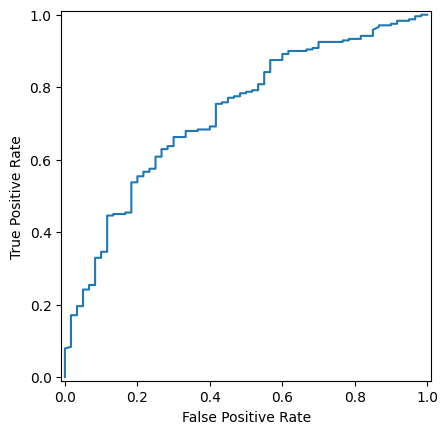

In [115]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(true_scores_train.argmax(dim=1), pred_scores_train[:,1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()